# I. Importing the required libraries

In [26]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# This notebook author: Reza Chu
# Last Editing Date: 31st May 2019

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

# II. Reading the data

In [2]:
# Data Directory
# Please edit according to your directory change.
dir_list = os.listdir('data/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'data/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

2452


,path,source,actor,gender,intensity,statement,repetition,emotion
0,data/Actor_01/03-02-04-02-02-01-01.wav,2,1,male,1,1,0,4
1,data/Actor_01/03-01-04-02-01-02-01.wav,1,1,male,1,0,1,4
2,data/Actor_01/03-02-05-02-01-01-01.wav,2,1,male,1,0,0,5
3,data/Actor_01/03-01-04-01-01-02-01.wav,1,1,male,0,0,1,4
4,data/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2


# III. Plotting the audio file's waveform and its spectrogram

In [5]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

data/Actor_10/03-01-05-01-01-02-10.wav


(22050, array([-3.77176912e-05, -1.10931855e-04,  2.90319556e-04, ...,
         2.24706928e-05, -3.84291661e-06,  0.00000000e+00], dtype=float32))

In [6]:
len(samples), sample_rate

(88289, 22050)

In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [8]:
sample_rate/ len(samples)

0.24974798672541312

Text(0.5, 0, 'Seconds')

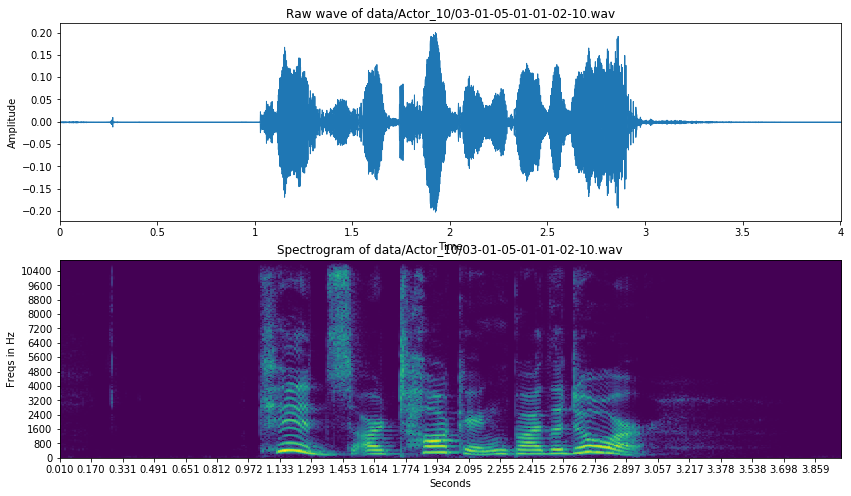

In [9]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [11]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 9.8497745e-05,  1.0179912e-04, -3.2110562e-05, ...,
         2.2454399e-03,  1.4861705e-03,  4.5785634e-04], dtype=float32),
 array([22016, 66560]))

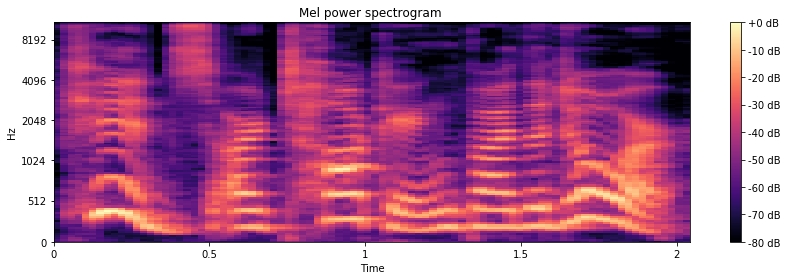

In [12]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

/home/reza/anaconda3/envs/dg/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



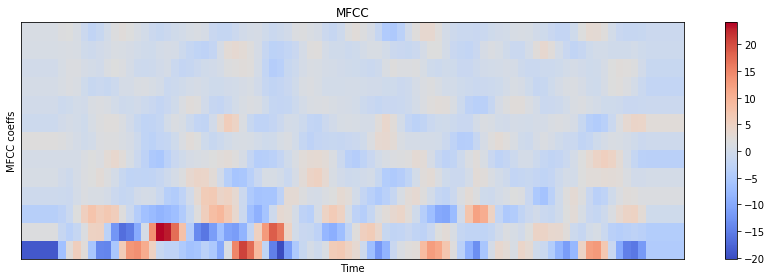

In [13]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [14]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [15]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [16]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [17]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

2452

In [18]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

2452

In [19]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

2452

In [20]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

2452

In [21]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-02-04-02-02-01-01.wav,2,1,male,1,1,0,4,male_negative
1,data/Actor_01/03-01-04-02-01-02-01.wav,1,1,male,1,0,1,4,male_negative
2,data/Actor_01/03-02-05-02-01-01-01.wav,2,1,male,1,0,0,5,male_negative
3,data/Actor_01/03-01-04-01-01-02-01.wav,1,1,male,0,0,1,4,male_negative
4,data/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2,male_positive


In [22]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_positive', 'female_positive',
       'male_none', 'female_none'],
      dtype='object')


In [23]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

<class 'pandas.core.series.Series'>


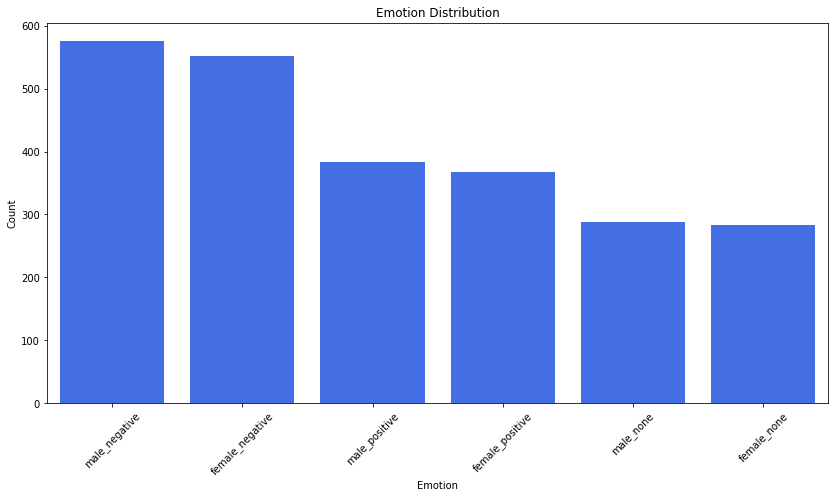

In [24]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [31]:
# Female Data Set

## Uncomment all below to use Female set 

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [32]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

800


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_01/03-02-04-02-02-01-01.wav,2,1,male,1,1,0,4,male_negative
1,data/Actor_01/03-01-04-02-01-02-01.wav,1,1,male,1,0,1,4,male_negative
2,data/Actor_01/03-02-05-02-01-01-01.wav,2,1,male,1,0,0,5,male_negative
3,data/Actor_01/03-01-04-01-01-02-01.wav,1,1,male,0,0,1,4,male_negative
4,data/Actor_01/03-01-02-01-02-01-01.wav,1,1,male,0,1,0,2,male_positive


In [33]:
print (len(data3_df))
data3_df.head()

160


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,data/Actor_21/03-01-04-02-02-02-21.wav,1,21,male,1,1,1,4,male_negative
1,data/Actor_21/03-02-03-02-01-01-21.wav,2,21,male,1,0,0,3,male_positive
2,data/Actor_21/03-02-05-01-02-01-21.wav,2,21,male,0,1,0,5,male_negative
3,data/Actor_21/03-01-02-02-01-02-21.wav,1,21,male,1,0,1,2,male_positive
4,data/Actor_21/03-01-02-02-02-01-21.wav,1,21,male,1,1,0,2,male_positive


# VI. Getting the features of audio files using librosa

In [35]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 800/800 [00:31<00:00, 25.69it/s]


In [36]:
data.head()

,feature
0,"[-56.91284250420127, -56.48526874950596, -56.5..."
1,"[-62.104852507780045, -62.104852507780045, -62..."
2,"[-45.968126964359264, -45.81826183337232, -44...."
3,"[-67.73615146024396, -67.77801795322442, -66.7..."
4,"[-69.67328949566406, -69.69331084873151, -69.6..."


In [37]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [38]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-56.912843,-56.485269,-56.501424,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,...,-44.822108,-46.451407,-46.669580,-46.596475,-47.113484,-46.768849,-48.650488,-52.294436,-51.852247,-47.143469
1,-62.104853,-62.104853,-62.104853,-62.037936,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,...,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853
2,-45.968127,-45.818262,-44.713754,-43.853780,-44.876142,-45.742182,-44.462401,-45.629232,-45.794369,-44.506374,...,-17.042166,-17.049920,-18.028540,-16.300012,-15.349774,-14.373643,-14.399101,-13.917189,-14.184953,-14.288989
3,-67.736151,-67.778018,-66.746144,-65.957883,-67.736151,-67.736151,-67.736151,-67.258683,-67.736151,-67.736151,...,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311


In [39]:
newdf = pd.concat([df3,labels], axis=1)

In [40]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

800

In [41]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-56.912843,-56.485269,-56.501424,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,...,-46.451407,-46.669580,-46.596475,-47.113484,-46.768849,-48.650488,-52.294436,-51.852247,-47.143469,male_negative
1,-62.104853,-62.104853,-62.104853,-62.037936,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,...,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,male_negative
2,-45.968127,-45.818262,-44.713754,-43.853780,-44.876142,-45.742182,-44.462401,-45.629232,-45.794369,-44.506374,...,-17.049920,-18.028540,-16.300012,-15.349774,-14.373643,-14.399101,-13.917189,-14.184953,-14.288989,male_negative
3,-67.736151,-67.778018,-66.746144,-65.957883,-67.736151,-67.736151,-67.736151,-67.258683,-67.736151,-67.736151,...,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,male_negative
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive
5,-54.181857,-53.653303,-52.179519,-52.163266,-53.387515,-53.853849,-52.760702,-51.047829,-50.953316,-50.094384,...,-52.989496,-52.172938,-51.714458,-53.732064,-54.112915,-52.875975,-52.818990,-52.377234,-53.531375,male_positive
6,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,-68.049082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_negative
7,-61.542955,-61.670297,-61.663520,-61.675594,-59.627474,-58.578270,-60.384651,-60.370816,-59.209070,-59.793678,...,-40.469880,-41.462666,-40.453254,-42.066735,-42.704448,-41.112258,-41.137339,-41.213322,-38.552507,male_positive
8,-55.815831,-55.791512,-55.661960,-55.702223,-55.800005,-55.791471,-55.815808,-55.815831,-55.815831,-55.676474,...,-35.430449,-34.440064,-34.951263,-33.887344,-34.126421,-33.674242,-34.369253,-36.464253,-38.092677,male_positive
9,-63.557785,-63.707485,-63.975054,-63.975054,-63.975054,-63.975054,-63.975054,-63.975054,-63.975054,-63.975054,...,-39.142542,-40.554657,-40.985578,-41.396802,-40.635562,-40.026052,-40.481173,-39.127330,-34.881790,male_positive


In [42]:
rnewdf.isnull().sum().sum()

2284

In [43]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-56.912843,-56.485269,-56.501424,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,...,-46.451407,-46.669580,-46.596475,-47.113484,-46.768849,-48.650488,-52.294436,-51.852247,-47.143469,male_negative
1,-62.104853,-62.104853,-62.104853,-62.037936,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,...,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,male_negative
2,-45.968127,-45.818262,-44.713754,-43.853780,-44.876142,-45.742182,-44.462401,-45.629232,-45.794369,-44.506374,...,-17.049920,-18.028540,-16.300012,-15.349774,-14.373643,-14.399101,-13.917189,-14.184953,-14.288989,male_negative
3,-67.736151,-67.778018,-66.746144,-65.957883,-67.736151,-67.736151,-67.736151,-67.258683,-67.736151,-67.736151,...,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,male_negative
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive


# VII. Data Augmentation

In [44]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




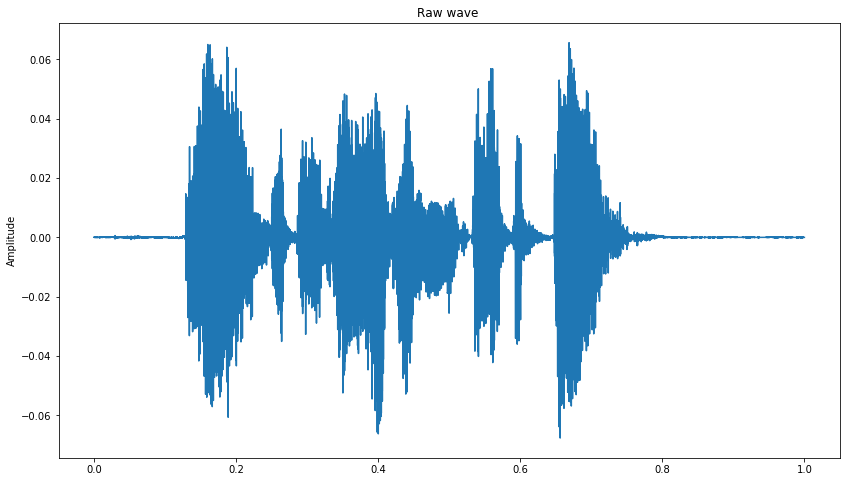

In [45]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

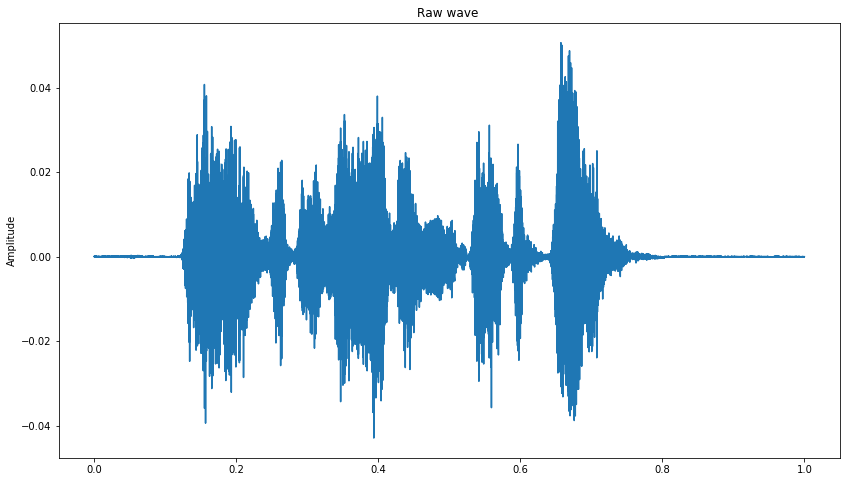

In [46]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [47]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 800/800 [00:33<00:00, 23.54it/s]


In [48]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|██████████| 800/800 [02:32<00:00,  6.17it/s]


In [49]:
len(syn_data1), len(syn_data2) 

(800, 800)

In [50]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [51]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

800

In [52]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-42.655028,-41.631001,-42.889592,-45.655462,-43.978180,-43.158309,-42.575014,-43.440535,-46.040724,-46.640464,...,-39.005377,-38.213447,-38.433231,-39.303873,-39.492250,-40.346354,-40.741678,-41.220059,-44.056411,male_negative
1,-55.219944,-52.616484,-52.286107,-52.161278,-53.126588,-55.292935,-54.199089,-52.846805,-53.711407,-55.357601,...,-52.011125,-52.840875,-54.944207,-53.116663,-52.679384,-53.999925,-53.172648,-53.296122,-54.285751,male_negative
2,-32.440129,-31.861092,-34.672080,-34.073788,-32.633722,-33.913732,-33.039583,-33.686151,-33.661578,-31.001432,...,-16.046093,-17.121549,-15.584639,-14.820404,-14.208298,-14.230996,-13.517215,-13.323313,-12.951925,male_negative
3,-61.922411,-62.215679,-58.022851,-57.290941,-61.027303,-59.469569,-58.475640,-59.944717,-60.281107,-60.326236,...,-60.675019,-60.296145,-61.405229,-62.748245,-60.925061,-60.605445,-61.236013,-60.299258,-59.810118,male_negative
4,-61.966295,-59.694255,-59.229291,-58.562706,-58.993120,-60.443855,-61.110881,-58.887908,-60.432024,-61.621168,...,-59.579235,-58.850751,-59.550176,-58.473981,-58.458420,-57.595753,-57.773556,-59.198322,-60.918181,male_positive


In [53]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

800

In [54]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-57.753215,-57.455891,-58.015750,-58.366476,-58.366476,-58.366476,-58.366476,-58.366476,-58.366476,-58.366476,...,-48.784671,-50.291433,-50.476648,-49.922888,-49.717019,-50.676514,-53.910571,-55.820576,-57.067588,male_negative
1,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,...,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,-62.773059,male_negative
2,-47.605232,-46.625293,-47.425215,-49.043574,-48.964560,-48.288764,-48.906125,-51.401454,-49.835744,-47.608633,...,-21.055637,-21.569586,-20.796359,-19.045929,-18.160538,-17.901236,-17.885066,-17.290123,-19.650012,male_negative
3,-69.802849,-70.034258,-69.537954,-69.222710,-69.773514,-69.773514,-69.773514,-69.617643,-69.773514,-69.773514,...,-69.773514,-69.773514,-69.773514,-69.773514,-69.773514,-69.773514,-69.773514,-69.773514,-69.773514,male_negative
4,-71.245390,-71.097453,-71.678199,-71.678199,-71.678199,-71.678199,-71.678199,-71.678199,-71.678199,-70.730889,...,-71.678199,-71.678199,-71.678199,-71.678199,-71.678199,-71.614492,-71.678199,-71.678199,-71.678199,male_positive


In [55]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-56.912843,-56.485269,-56.501424,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,-57.221756,...,-46.451407,-46.669580,-46.596475,-47.113484,-46.768849,-48.650488,-52.294436,-51.852247,-47.143469,male_negative
1,-62.104853,-62.104853,-62.104853,-62.037936,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,...,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,-62.104853,male_negative
2,-45.968127,-45.818262,-44.713754,-43.853780,-44.876142,-45.742182,-44.462401,-45.629232,-45.794369,-44.506374,...,-17.049920,-18.028540,-16.300012,-15.349774,-14.373643,-14.399101,-13.917189,-14.184953,-14.288989,male_negative
3,-67.736151,-67.778018,-66.746144,-65.957883,-67.736151,-67.736151,-67.736151,-67.258683,-67.736151,-67.736151,...,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,-67.736151,male_negative
4,-69.673289,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.693311,-69.620774,-69.693311,-68.906572,...,-69.693311,-69.693311,-69.693311,-69.693311,-69.383522,-69.693311,-69.693311,-69.693311,-69.693311,male_positive


In [56]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

StratifiedShuffleSplit(n_splits=1, random_state=12, test_size=0.2,
            train_size=None)


In [57]:
y_train.value_counts()

male_negative    1152
male_positive     768
Name: label, dtype: int64

In [58]:
y_test.value_counts()

male_negative    288
male_positive    192
Name: label, dtype: int64

In [59]:
X_train.isna().sum().sum()

0

In [60]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [61]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [62]:
X_train.shape

(1920, 259)

# VIII. Changing dimension for CNN model

In [63]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [64]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [65]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [66]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [67]:
# Plotting Model Summary

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)           0         
__________

In [68]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [70]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Train on 1920 samples, validate on 480 samples
Epoch 1/700
1920/1920 [==============================] - 4s 2ms/step - loss: 0.6579 - acc: 0.5854 - fscore: 0.5854 - val_loss: 0.6631 - val_acc: 0.5500 - val_fscore: 0.5500
Epoch 2/700
1920/1920 [==============================] - 2s 788us/step - loss: 0.6414 - acc: 0.6104 - fscore: 0.6104 - val_loss: 0.6575 - val_acc: 0.5667 - val_fscore: 0.5667
Epoch 3/700
1920/1920 [==============================] - 2s 969us/step - loss: 0.6243 - acc: 0.6219 - fscore: 0.6219 - val_loss: 0.6489 - val_acc: 0.6083 - val_fscore: 0.6083
Epoch 4/700
1920/1920 [==============================] - 2s 857us/step - loss: 0.6199 - acc: 0.6333 - fscore: 0.6333 - val_loss: 0.6462 - val_acc: 0.5917 - val_fscore: 0.5917
Epoch 5/700
1920/1920 [==============================] - 2s 929us/step - loss: 0.6147 - acc: 0.6401 - fscore: 0.6401 - val_loss: 0.6524 - val_acc: 0.6042 - val_fscore: 0.6042
Epoch 6/700
1920/1920 [==============================] - 2s 854us/step - loss: 0

1920/1920 [==============================] - 1s 746us/step - loss: 0.4012 - acc: 0.8297 - fscore: 0.8297 - val_loss: 0.5261 - val_acc: 0.7604 - val_fscore: 0.7604
Epoch 94/700
1920/1920 [==============================] - 1s 741us/step - loss: 0.4043 - acc: 0.8292 - fscore: 0.8292 - val_loss: 0.5111 - val_acc: 0.7792 - val_fscore: 0.7792
Epoch 95/700
1920/1920 [==============================] - 1s 741us/step - loss: 0.4024 - acc: 0.8203 - fscore: 0.8203 - val_loss: 0.5196 - val_acc: 0.7708 - val_fscore: 0.7708
Epoch 96/700
1920/1920 [==============================] - 1s 735us/step - loss: 0.3896 - acc: 0.8391 - fscore: 0.8391 - val_loss: 0.5235 - val_acc: 0.7208 - val_fscore: 0.7208
Epoch 97/700
1920/1920 [==============================] - 1s 745us/step - loss: 0.3871 - acc: 0.8406 - fscore: 0.8406 - val_loss: 0.5051 - val_acc: 0.7562 - val_fscore: 0.7562
Epoch 98/700
1920/1920 [==============================] - 1s 753us/step - loss: 0.3913 - acc: 0.8385 - fscore: 0.8385 - val_loss: 0.5

1920/1920 [==============================] - 1s 757us/step - loss: 0.1912 - acc: 0.9370 - fscore: 0.9370 - val_loss: 0.3850 - val_acc: 0.8271 - val_fscore: 0.8271
Epoch 186/700
1920/1920 [==============================] - 1s 737us/step - loss: 0.2034 - acc: 0.9323 - fscore: 0.9323 - val_loss: 0.4120 - val_acc: 0.8167 - val_fscore: 0.8167
Epoch 187/700
1920/1920 [==============================] - 1s 744us/step - loss: 0.1848 - acc: 0.9422 - fscore: 0.9422 - val_loss: 0.4090 - val_acc: 0.8125 - val_fscore: 0.8125
Epoch 188/700
1920/1920 [==============================] - 1s 749us/step - loss: 0.1847 - acc: 0.9385 - fscore: 0.9385 - val_loss: 0.4064 - val_acc: 0.8125 - val_fscore: 0.8125
Epoch 189/700
1920/1920 [==============================] - 1s 751us/step - loss: 0.1888 - acc: 0.9339 - fscore: 0.9339 - val_loss: 0.4149 - val_acc: 0.8000 - val_fscore: 0.8000
Epoch 190/700
1920/1920 [==============================] - 1s 750us/step - loss: 0.1842 - acc: 0.9437 - fscore: 0.9437 - val_loss

1920/1920 [==============================] - 1s 751us/step - loss: 0.0833 - acc: 0.9755 - fscore: 0.9755 - val_loss: 0.2919 - val_acc: 0.8729 - val_fscore: 0.8729
Epoch 278/700
1920/1920 [==============================] - 1s 742us/step - loss: 0.0842 - acc: 0.9807 - fscore: 0.9807 - val_loss: 0.2311 - val_acc: 0.9104 - val_fscore: 0.9104
Epoch 279/700
1920/1920 [==============================] - 1s 737us/step - loss: 0.0851 - acc: 0.9786 - fscore: 0.9786 - val_loss: 0.2428 - val_acc: 0.9146 - val_fscore: 0.9146
Epoch 280/700
1920/1920 [==============================] - 1s 756us/step - loss: 0.0746 - acc: 0.9854 - fscore: 0.9854 - val_loss: 0.3275 - val_acc: 0.8479 - val_fscore: 0.8479
Epoch 281/700
1920/1920 [==============================] - 1s 736us/step - loss: 0.0860 - acc: 0.9807 - fscore: 0.9807 - val_loss: 0.2651 - val_acc: 0.9021 - val_fscore: 0.9021
Epoch 282/700
1920/1920 [==============================] - 1s 745us/step - loss: 0.0717 - acc: 0.9802 - fscore: 0.9802 - val_loss

1920/1920 [==============================] - 2s 1ms/step - loss: 0.0405 - acc: 0.9906 - fscore: 0.9906 - val_loss: 0.2146 - val_acc: 0.9125 - val_fscore: 0.9125
Epoch 370/700
1920/1920 [==============================] - 2s 930us/step - loss: 0.0376 - acc: 0.9948 - fscore: 0.9948 - val_loss: 0.2122 - val_acc: 0.9271 - val_fscore: 0.9271
Epoch 371/700
1920/1920 [==============================] - 2s 894us/step - loss: 0.0385 - acc: 0.9927 - fscore: 0.9927 - val_loss: 0.3235 - val_acc: 0.8625 - val_fscore: 0.8625
Epoch 372/700
1920/1920 [==============================] - 2s 828us/step - loss: 0.0423 - acc: 0.9896 - fscore: 0.9896 - val_loss: 0.3636 - val_acc: 0.8250 - val_fscore: 0.8250
Epoch 373/700
1920/1920 [==============================] - 2s 925us/step - loss: 0.0393 - acc: 0.9938 - fscore: 0.9937 - val_loss: 0.2442 - val_acc: 0.9021 - val_fscore: 0.9021
Epoch 374/700
1920/1920 [==============================] - 1s 778us/step - loss: 0.0406 - acc: 0.9927 - fscore: 0.9927 - val_loss: 

1920/1920 [==============================] - 2s 828us/step - loss: 0.0236 - acc: 0.9974 - fscore: 0.9974 - val_loss: 0.1788 - val_acc: 0.9271 - val_fscore: 0.9271
Epoch 462/700
1920/1920 [==============================] - 2s 828us/step - loss: 0.0260 - acc: 0.9958 - fscore: 0.9958 - val_loss: 0.2460 - val_acc: 0.8979 - val_fscore: 0.8979
Epoch 463/700
1920/1920 [==============================] - 1s 757us/step - loss: 0.0224 - acc: 0.9979 - fscore: 0.9979 - val_loss: 0.1673 - val_acc: 0.9333 - val_fscore: 0.9333
Epoch 464/700
1920/1920 [==============================] - 2s 902us/step - loss: 0.0222 - acc: 0.9974 - fscore: 0.9974 - val_loss: 0.1954 - val_acc: 0.9208 - val_fscore: 0.9208
Epoch 465/700
1920/1920 [==============================] - 2s 816us/step - loss: 0.0231 - acc: 0.9969 - fscore: 0.9969 - val_loss: 0.1839 - val_acc: 0.9250 - val_fscore: 0.9250
Epoch 466/700
1920/1920 [==============================] - 2s 858us/step - loss: 0.0253 - acc: 0.9943 - fscore: 0.9943 - val_loss

1920/1920 [==============================] - 2s 904us/step - loss: 0.0155 - acc: 0.9969 - fscore: 0.9969 - val_loss: 0.1666 - val_acc: 0.9417 - val_fscore: 0.9417
Epoch 554/700
1920/1920 [==============================] - 2s 787us/step - loss: 0.0140 - acc: 0.9990 - fscore: 0.9990 - val_loss: 0.1720 - val_acc: 0.9333 - val_fscore: 0.9333
Epoch 555/700
1920/1920 [==============================] - 2s 846us/step - loss: 0.0159 - acc: 0.9969 - fscore: 0.9969 - val_loss: 0.1860 - val_acc: 0.9354 - val_fscore: 0.9354
Epoch 556/700
1920/1920 [==============================] - 2s 936us/step - loss: 0.0157 - acc: 0.9979 - fscore: 0.9979 - val_loss: 0.1595 - val_acc: 0.9417 - val_fscore: 0.9417
Epoch 557/700
1920/1920 [==============================] - 2s 858us/step - loss: 0.0168 - acc: 0.9979 - fscore: 0.9979 - val_loss: 0.1647 - val_acc: 0.9375 - val_fscore: 0.9375
Epoch 558/700
1920/1920 [==============================] - 2s 938us/step - loss: 0.0156 - acc: 0.9974 - fscore: 0.9974 - val_loss

1920/1920 [==============================] - 1s 740us/step - loss: 0.0154 - acc: 0.9974 - fscore: 0.9974 - val_loss: 0.1622 - val_acc: 0.9354 - val_fscore: 0.9354
Epoch 646/700
1920/1920 [==============================] - 1s 752us/step - loss: 0.0147 - acc: 0.9974 - fscore: 0.9974 - val_loss: 0.1627 - val_acc: 0.9375 - val_fscore: 0.9375
Epoch 647/700
1920/1920 [==============================] - 1s 760us/step - loss: 0.0132 - acc: 0.9990 - fscore: 0.9990 - val_loss: 0.1646 - val_acc: 0.9292 - val_fscore: 0.9292
Epoch 648/700
1920/1920 [==============================] - 1s 736us/step - loss: 0.0152 - acc: 0.9984 - fscore: 0.9984 - val_loss: 0.1587 - val_acc: 0.9313 - val_fscore: 0.9312
Epoch 649/700
1920/1920 [==============================] - 1s 742us/step - loss: 0.0150 - acc: 0.9979 - fscore: 0.9979 - val_loss: 0.1669 - val_acc: 0.9292 - val_fscore: 0.9292
Epoch 650/700
1920/1920 [==============================] - 1s 742us/step - loss: 0.0145 - acc: 0.9979 - fscore: 0.9979 - val_loss

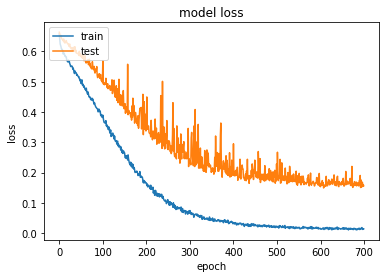

In [71]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [73]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [74]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 93.96%


# X. Predicting emotions on the test data

In [75]:
len(data3_df)

160

In [76]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 160/160 [00:05<00:00, 26.86it/s]


In [77]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

160/160 [==============================] - 0s 978us/step


In [78]:
preds

array([[9.02437747e-01, 9.75623056e-02],
       [7.74625828e-03, 9.92253721e-01],
       [9.83769000e-01, 1.62310582e-02],
       [1.44755363e-01, 8.55244637e-01],
       [2.51911819e-01, 7.48088181e-01],
       [9.93456066e-01, 6.54396275e-03],
       [2.94017226e-01, 7.05982745e-01],
       [9.54675138e-01, 4.53248359e-02],
       [1.00791091e-02, 9.89920855e-01],
       [2.56100714e-01, 7.43899286e-01],
       [2.40712896e-01, 7.59287059e-01],
       [2.41282061e-02, 9.75871861e-01],
       [8.25557590e-01, 1.74442455e-01],
       [9.92534518e-01, 7.46552832e-03],
       [2.59766299e-02, 9.74023402e-01],
       [4.62669402e-01, 5.37330568e-01],
       [1.32880300e-01, 8.67119730e-01],
       [1.68901440e-02, 9.83109832e-01],
       [6.21189028e-02, 9.37881052e-01],
       [7.54640818e-01, 2.45359138e-01],
       [6.66550770e-02, 9.33344901e-01],
       [9.95067477e-01, 4.93251253e-03],
       [9.22456663e-03, 9.90775406e-01],
       [9.98589694e-01, 1.41029467e-03],
       [9.727742

In [79]:
preds1=preds.argmax(axis=1)

In [80]:
preds1

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0])

In [81]:
abc = preds1.astype(int).flatten()

In [82]:
predictions = (lb.inverse_transform((abc)))

In [83]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_negative
1,male_positive
2,male_negative
3,male_positive
4,male_positive
5,male_negative
6,male_positive
7,male_negative
8,male_positive
9,male_positive


In [84]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [85]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_negative
1,male_positive
2,male_negative
3,male_positive
4,male_positive
5,male_negative
6,male_positive
7,male_positive
8,male_positive
9,male_positive


In [86]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [87]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_positive
21,male_positive,male_negative
22,male_positive,male_positive
23,male_negative,male_negative
24,male_negative,male_negative
25,male_negative,male_negative
26,male_negative,male_negative
27,male_negative,male_positive
28,male_negative,male_positive
29,male_positive,male_positive


In [88]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_negative,96
male_positive,64


In [89]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_negative,97
male_positive,63


In [90]:
finaldf.to_csv('Predictions.csv', index=False)

In [91]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [92]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

66.875

In [93]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

65.40328831953

In [94]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[70, 26],
       [27, 37]])

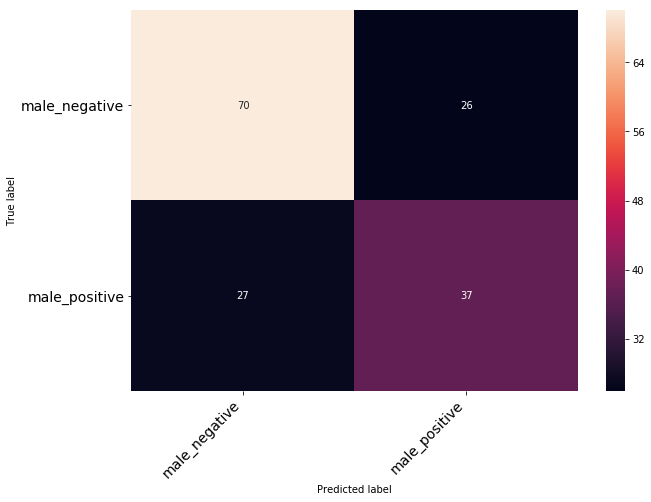

In [95]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)